In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# set seed for reproducibility
np.random.seed(1)

import contractions
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from gsdmm import MovieGroupProcess

import yake

sid = SentimentIntensityAnalyzer()

## SG

In [2]:
wfo_sg = pd.read_csv("twitter data scrape/WFH SG (Apr 20 - Feb 23).csv")
wfo_sg.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/winanci/status/16246791815...,2023-02-12 07:57:56+00:00,Rain!! I was joking that I wish it would rain ...,Rain!! I was joking that I wish it would rain ...,1624679181543182336,https://twitter.com/winanci,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['singaporeweather', 'rain', 'workworkwork', '...",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,51.0,NaN
1,https://twitter.com/winanci/status/16246532082...,2023-02-12 06:14:44+00:00,Just Dance done.\n#justdance #workworkwork #wf...,Just Dance done.\n#justdance #workworkwork #wf...,1624653208298614785,https://twitter.com/winanci,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['justdance', 'workworkwork', 'wfh']",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,14.0,NaN
2,https://twitter.com/animesh1977/status/1619283...,2023-01-28 10:35:38+00:00,Pretending to work from bro @KrishanK_Sharma h...,Pretending to work from bro @KrishanK_Sharma h...,1619283048260067328,https://twitter.com/animesh1977,0,0,0,0,...,NaN,NaN,"[User(username='KrishanK_Sharma', id=433040454...","Coordinates(longitude=103.86733961273401, lati...","Place(id='0866fdf7f2940001', fullName='PAssion...",['WFH'],NaN,NaN,34.0,NaN
3,https://twitter.com/winanci/status/16173992191...,2023-01-23 05:49:58+00:00,"Raining so much today, food delivery is a reas...","Raining so much today, food delivery is a reas...",1617399219194585097,https://twitter.com/winanci,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['4fingers', 'foodisamazing', 'workworkwork', ...",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,32.0,NaN
4,https://twitter.com/winanci/status/16145637630...,2023-01-15 10:02:52+00:00,A bit of walk to dinner to get my eyes rested....,A bit of walk to dinner to get my eyes rested....,1614563763046203395,https://twitter.com/winanci,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['wfh', 'weekendwork', 'workworkwork']",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,10.0,NaN


In [3]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text])

In [4]:
def clean_tweet(tweet, column):
    ## remove contractions
    tweet[column] = tweet[column].apply(lambda x: [contractions.fix(word) for word in x.split()])

    ## convert back into string so that tokenization can be done
    tweet[column] = [' '.join(map(str, l)) for l in tweet[column]]

    ## tokenize
    tweet[column] = tweet[column].apply(word_tokenize)

    ## convert tokens to lowercase
    tweet[column] = tweet[column].apply(lambda x: [word.lower() for word in x])

    ## remove punctuations and numerics
    tweet[column] = tweet[column].apply(lambda x: [word for word in x if re.search('^[a-z]+$',word)])

    ## remove stopwords
    stop_list = stopwords.words('english')
    stop_list.extend(["&amp", "amp", "http", "https"])
    tweet[column] = tweet[column].apply(lambda x: [word for word in x if word not in stop_list])
    tweet[column] = tweet[column].apply(lambda x: lemmatize_words(x))
    return tweet                            

In [5]:
clean_tweet(wfo_sg, "renderedContent")

docs = []
for sentence in wfo_sg.renderedContent:
    words = word_tokenize(sentence)
    docs.append(words)
docs

[['rain',
  'joking',
  'wish',
  'would',
  'rain',
  'day',
  'wfh',
  'hour',
  'singaporeweather',
  'rain',
  'workworkwork',
  'wfh',
  'bedok',
  'singapore'],
 ['dance', 'done', 'justdance', 'workworkwork', 'wfh', 'bedok', 'singapore'],
 ['pretending', 'work', 'bro', 'home', 'wfh'],
 ['raining',
  'much',
  'today',
  'food',
  'delivery',
  'reasonable',
  'option',
  'wfh',
  'foodisamazing',
  'workworkwork',
  'wfh',
  'bedok',
  'singapore'],
 ['bit',
  'walk',
  'dinner',
  'get',
  'eye',
  'rested',
  'wfh',
  'weekendwork',
  'workworkwork',
  'bedok',
  'singapore'],
 ['need', 'wfh', 'job', 'could', 'cover', 'monthly', 'salary'],
 ['call', 'direct', 'ping', 'first', 'wfh'],
 ['rainy',
  'friday',
  'deep',
  'reflection',
  'metaverse',
  'philosophy',
  'tying',
  'loose',
  'end',
  'happy',
  'tgif',
  'everyone',
  'wfh',
  'tgif',
  'singapore'],
 ['father',
  'bought',
  'prata',
  'lunch',
  'today',
  'understood',
  'assignment',
  'yaaaass',
  'wfh'],
 ['got

In [6]:
dictionary = gensim.corpora.Dictionary(docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [7]:
mgp = MovieGroupProcess(K=4, alpha=0.1, beta=1, n_iters=30)

y = mgp.fit(docs, len(dictionary))

In stage 0: transferred 179 clusters with 4 clusters populated
In stage 1: transferred 114 clusters with 4 clusters populated
In stage 2: transferred 108 clusters with 4 clusters populated
In stage 3: transferred 65 clusters with 4 clusters populated
In stage 4: transferred 63 clusters with 4 clusters populated
In stage 5: transferred 42 clusters with 4 clusters populated
In stage 6: transferred 39 clusters with 4 clusters populated
In stage 7: transferred 38 clusters with 4 clusters populated
In stage 8: transferred 35 clusters with 4 clusters populated
In stage 9: transferred 39 clusters with 4 clusters populated
In stage 10: transferred 43 clusters with 3 clusters populated
In stage 11: transferred 47 clusters with 3 clusters populated
In stage 12: transferred 37 clusters with 3 clusters populated
In stage 13: transferred 42 clusters with 3 clusters populated
In stage 14: transferred 40 clusters with 3 clusters populated
In stage 15: transferred 46 clusters with 3 clusters populated

In [8]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = [i for i in doc_count.argsort()[::-1] if doc_count[i] > 0]
print('Most important clusters (by number of docs inside):', top_index)

Number of documents per topic : [172  12   0  96]
Most important clusters (by number of docs inside): [0, 3, 1]


In [9]:
def top_words(mgp, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print('-'*120)

In [10]:
# Show the top 10 words in term frequency for each cluster 

top_words(mgp, top_index, 10)

Cluster 0 : [('wfh', 178), ('singapore', 81), ('work', 30), ('day', 29), ('home', 24), ('bukit', 20), ('panjang', 20), ('time', 18), ('teampixel', 16), ('today', 15)]
------------------------------------------------------------------------------------------------------------------------
Cluster 3 : [('wfh', 98), ('stayhome', 42), ('singapore', 40), ('staysafe', 26), ('coronavirus', 20), ('lunch', 16), ('circuitbreaker', 16), ('day', 12), ('zoom', 11), ('mask', 9)]
------------------------------------------------------------------------------------------------------------------------
Cluster 1 : [('wfh', 12), ('ai', 4), ('iot', 4), ('light', 4), ('uib', 3), ('everyone', 2), ('mic', 2), ('workfromhome', 2), ('ceo', 2), ('tobyruckert', 2)]
------------------------------------------------------------------------------------------------------------------------


In [11]:
wfo_sg["Topic"] = y
wfo_sg.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic
0,https://twitter.com/winanci/status/16246791815...,2023-02-12 07:57:56+00:00,Rain!! I was joking that I wish it would rain ...,rain joking wish would rain day wfh hour singa...,1624679181543182336,https://twitter.com/winanci,0,0,0,0,...,NaN,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['singaporeweather', 'rain', 'workworkwork', '...",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,51.0,NaN,0
1,https://twitter.com/winanci/status/16246532082...,2023-02-12 06:14:44+00:00,Just Dance done.\n#justdance #workworkwork #wf...,dance done justdance workworkwork wfh bedok si...,1624653208298614785,https://twitter.com/winanci,0,0,0,0,...,NaN,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['justdance', 'workworkwork', 'wfh']",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,14.0,NaN,0
2,https://twitter.com/animesh1977/status/1619283...,2023-01-28 10:35:38+00:00,Pretending to work from bro @KrishanK_Sharma h...,pretending work bro home wfh,1619283048260067328,https://twitter.com/animesh1977,0,0,0,0,...,NaN,"[User(username='KrishanK_Sharma', id=433040454...","Coordinates(longitude=103.86733961273401, lati...","Place(id='0866fdf7f2940001', fullName='PAssion...",['WFH'],NaN,NaN,34.0,NaN,0
3,https://twitter.com/winanci/status/16173992191...,2023-01-23 05:49:58+00:00,"Raining so much today, food delivery is a reas...",raining much today food delivery reasonable op...,1617399219194585097,https://twitter.com/winanci,0,0,0,0,...,NaN,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['4fingers', 'foodisamazing', 'workworkwork', ...",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,32.0,NaN,0
4,https://twitter.com/winanci/status/16145637630...,2023-01-15 10:02:52+00:00,A bit of walk to dinner to get my eyes rested....,bit walk dinner get eye rested wfh weekendwork...,1614563763046203395,https://twitter.com/winanci,0,0,0,0,...,NaN,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['wfh', 'weekendwork', 'workworkwork']",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,10.0,NaN,0


In [12]:
# Topic distribution

wfo_sg.Topic.value_counts(dropna=False)

0    172
3     96
1     12
Name: Topic, dtype: int64

In [13]:
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.
    
    model: gsdmm instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include
    
    '''
    # create empty list to contain topics
    topics = []
    
    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]
         
        #create empty list to contain words
        topic = []
        
        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)
            
        #append topics to topics list    
        topics.append(topic)
    
    return topics

In [14]:
topics = get_topics_lists(mgp, top_index, 10)

cm_gsdmm = CoherenceModel(topics=topics, 
                          dictionary=dictionary, 
                          corpus=bow_corpus, 
                          texts=docs, 
                          coherence='c_v')

cm_gsdmm.get_coherence()

0.39534664719433144

In [15]:
def determine_sentiment(score):
    if score < 0:
        return "Negative"
    elif score > 0:
        return "Positive"
    else:
        return "Neutral"

In [16]:
wfo_sg["renderedContent"] = wfo_sg['renderedContent'].apply(lambda tweet:str(tweet))
sentiment_scores = wfo_sg['renderedContent'].apply(sid.polarity_scores)
sentiment_scores

0      {'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'comp...
1      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2      {'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'comp...
3      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                             ...                        
275    {'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...
276    {'neg': 0.087, 'neu': 0.415, 'pos': 0.498, 'co...
277    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
278    {'neg': 0.0, 'neu': 0.602, 'pos': 0.398, 'comp...
279    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: renderedContent, Length: 280, dtype: object

In [17]:
sentiments = sentiment_scores.apply(lambda x: x["compound"])
sentiment_label = sentiments.apply(determine_sentiment)
wfo_sg["Sentiment"] = sentiment_label
wfo_sg.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic,Sentiment
0,https://twitter.com/winanci/status/16246791815...,2023-02-12 07:57:56+00:00,Rain!! I was joking that I wish it would rain ...,rain joking wish would rain day wfh hour singa...,1624679181543182336,https://twitter.com/winanci,0,0,0,0,...,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['singaporeweather', 'rain', 'workworkwork', '...",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,51.0,NaN,0,Positive
1,https://twitter.com/winanci/status/16246532082...,2023-02-12 06:14:44+00:00,Just Dance done.\n#justdance #workworkwork #wf...,dance done justdance workworkwork wfh bedok si...,1624653208298614785,https://twitter.com/winanci,0,0,0,0,...,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['justdance', 'workworkwork', 'wfh']",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,14.0,NaN,0,Neutral
2,https://twitter.com/animesh1977/status/1619283...,2023-01-28 10:35:38+00:00,Pretending to work from bro @KrishanK_Sharma h...,pretending work bro home wfh,1619283048260067328,https://twitter.com/animesh1977,0,0,0,0,...,"[User(username='KrishanK_Sharma', id=433040454...","Coordinates(longitude=103.86733961273401, lati...","Place(id='0866fdf7f2940001', fullName='PAssion...",['WFH'],NaN,NaN,34.0,NaN,0,Positive
3,https://twitter.com/winanci/status/16173992191...,2023-01-23 05:49:58+00:00,"Raining so much today, food delivery is a reas...",raining much today food delivery reasonable op...,1617399219194585097,https://twitter.com/winanci,0,0,0,0,...,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['4fingers', 'foodisamazing', 'workworkwork', ...",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,32.0,NaN,0,Neutral
4,https://twitter.com/winanci/status/16145637630...,2023-01-15 10:02:52+00:00,A bit of walk to dinner to get my eyes rested....,bit walk dinner get eye rested wfh weekendwork...,1614563763046203395,https://twitter.com/winanci,0,0,0,0,...,NaN,"Coordinates(longitude=103.92880876, latitude=1...","Place(id='6635b2fcebd13c64', fullName='East Re...","['wfh', 'weekendwork', 'workworkwork']",NaN,SummaryCard(title='Waw Setia Ikan (@winanci) •...,10.0,NaN,0,Neutral


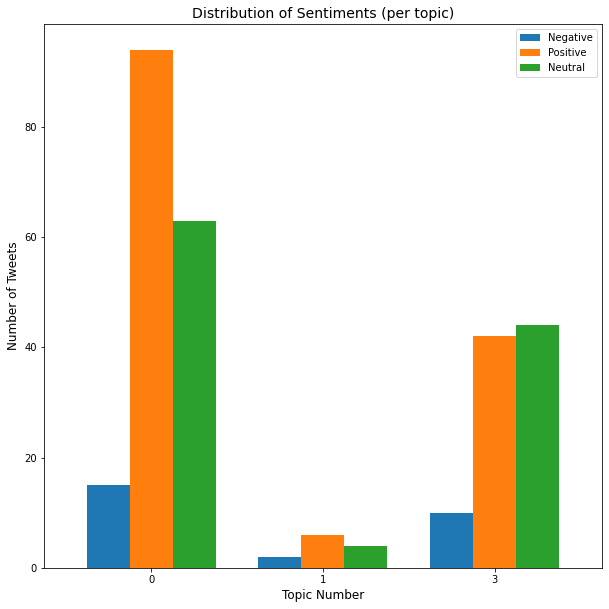

In [18]:
top_index.sort()
columns = ["Negative", "Positive", "Neutral"]
data = []

for topic in top_index:
    curr_topic = wfo_sg[wfo_sg["Topic"] == topic]
    negative, positive, neutral = len(curr_topic[curr_topic["Sentiment"] == "Negative"]), len(curr_topic[curr_topic["Sentiment"] == "Positive"]), len(curr_topic[curr_topic["Sentiment"] == "Neutral"])
    data.append([negative, positive, neutral])

topic_sentiment_df = pd.DataFrame(data, columns=columns, index=top_index)
topic_sentiment_df.plot(kind="bar", figsize=(10, 10), width=0.75)
plt.title("Distribution of Sentiments (per topic)", fontsize=14)
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.gca().xaxis.set_tick_params(rotation=0)
plt.show()

**Label topics**

In [19]:
kw_extractor = yake.KeywordExtractor(top=10)

In [20]:
cluster_keyphrases = dict()

for cluster in top_index:
    tweets = " ".join(wfo_sg[wfo_sg["Topic"] == cluster].renderedContent)
    cluster_keyphrases[cluster] = [kp[0] for kp in kw_extractor.extract_keywords(tweets)]

In [21]:
keyphrase_column_names = [f"Keyphrase {i}" for i in range(1, 11)]
cluster_keyphrases_df = pd.DataFrame.from_dict(cluster_keyphrases, orient="index", columns=keyphrase_column_names)
cluster_keyphrases_df

,Keyphrase 1,Keyphrase 2,Keyphrase 3,Keyphrase 4,Keyphrase 5,Keyphrase 6,Keyphrase 7,Keyphrase 8,Keyphrase 9,Keyphrase 10
0,bukit panjang singapore,panjang singapore wfh,wfh bukit panjang,wfh teampixel bukit,teampixel bukit panjang,wfh bedok singapore,singapore singapore wfh,teampixel wfh bukit,today wfh teampixel,singapore day wfh
1,uib ceo tobyruckert,iot aiot uib,iot aiot mckinsey,ceo tobyruckert lifeinapandemic,ceo tobyruckert latest,interviewed uib ceo,read uib ceo,iot thinkinh buying,aiot uib openforbusiness,tobyruckert lifeinapandemic podcast
3,wfh stayhome stayhomesg,wfh stayhome staysafe,pinkypiggustayhome wfh stayhome,stayhome stayhomesg stayhomeforsg,stayhome staysafe coronavirus,coronavirus stayhome staysafe,stayhome staysafe singapore,stayhome staysafe circuitbreaker,coronavirus wfh stayhome,wfh staysafe stayhealthy


In [22]:
for content in wfo_sg[(wfo_sg["Topic"] == 3) & (wfo_sg["Sentiment"] == "Positive")].renderedContent:
    print(content)

getting ready routine beforethewalk briskwalk wfh staysafe stayhealthy iampimster marina bay singapore
sunset proof matter happens every day end beautifully wfh sunset endoftheday briskwalking stayingfit staysafe reflextions marina bay sand
walking man best medicine hippocrates wfh earlybird staysafe stayhealthy briskwalking notsohruiyong hippocrates walking earlymorning alexandra park connector
honest premium pair earphone ever bought livelifelove sennheisser sennheisermomentum earphone gadget review productreview lifestyle tech techreview onlinemeeting ergonomics music wfh stayhome singapore sg
u spend much time urgent enough time important stephen covey stephencoveybrasil iampimster stephencovey dinner wfh staysafe namnam noodle bar
credit tiktok sorry understand mandarin something cute everyone wfh humour sgunited animation karaoke singapore
thanks great host suvarnakavan lovely wfh experience delicious pakistani food changi city point singapore
seafood soup noodle one fave weekend

## US (Washington)

In [23]:
wfo_us = pd.read_csv("twitter data scrape/WFH Washington (Jan 20 - Feb 23).csv")
wfo_us.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/Pasta_Mac/status/162118229...,2023-02-02 16:22:32+00:00,Does the fork match the keyboard or the keyboa...,Does the fork match the keyboard or the keyboa...,1621182291195187200,https://twitter.com/Pasta_Mac,0,0,0,0,...,NaN,NaN,NaN,"Coordinates(longitude=-76.9477, latitude=39.0795)","Place(id='092d7c3d0cba2fc2', fullName='Fairlan...","['bestwifeever', 'wfh', 'livingmybestlife', 'h...",NaN,SummaryCard(title='Emmanuel (@alejandro_drojan...,17.0,NaN
1,https://twitter.com/tomsommers1/status/1616934...,2023-01-21 23:02:27+00:00,"As #writers, our moment has come to bust out t...","As #writers, our moment has come to bust out t...",1616934278754885637,https://twitter.com/tomsommers1,0,3,4,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...","['writers', 'AI', 'authentic', 'journo', 'comm...",NaN,NaN,1132.0,NaN
2,https://twitter.com/tomsommers1/status/1607894...,2022-12-28 00:22:57+00:00,@AmmaraAhmedAwan @CaitlinKellyNYC After downsc...,@AmmaraAhmedAwan @CaitlinKellyNYC After downsc...,1607894837767938049,https://twitter.com/tomsommers1,0,0,3,0,...,1.607835e+18,https://twitter.com/AmmaraAhmedAwan,"[User(username='AmmaraAhmedAwan', id=159514332...","Coordinates(longitude=-77.220557, latitude=39....","Place(id='8c88f07c8666389d', fullName='Rockvil...","['travel', 'wfh', 'social', 'writing']",NaN,NaN,83.0,NaN
3,https://twitter.com/maxedoutsolar/status/16060...,2022-12-22 19:34:34+00:00,Shoutout to new followers! 👋\n\nI work in sola...,Shoutout to new followers! 👋\n\nI work in sola...,1606010323869106177,https://twitter.com/maxedoutsolar,0,4,11,0,...,NaN,NaN,NaN,"Coordinates(longitude=-77.022864, latitude=38....","Place(id='bb7522409d41c300', fullName='Takoma ...",['wfh'],NaN,NaN,283.0,NaN
4,https://twitter.com/DrKallschmidt/status/15881...,2022-11-03 15:29:15+00:00,So the next person to complain to me about how...,So the next person to complain to me about how...,1588191582284570625,https://twitter.com/DrKallschmidt,1,0,1,0,...,1.588192e+18,https://twitter.com/DrKallschmidt,NaN,"Coordinates(longitude=-77.172219, latitude=38....","Place(id='319ee7b36c9149da', fullName='Arlingt...",['wfh'],NaN,NaN,NaN,NaN


In [24]:
clean_tweet(wfo_us, "renderedContent")

docs = []
for sentence in wfo_us.renderedContent:
    words = word_tokenize(sentence)
    docs.append(words)
docs

[['fork',
  'match',
  'keyboard',
  'keyboard',
  'match',
  'fork',
  'anyway',
  'thank',
  'ladypecku',
  'amazing',
  'salad',
  'yo',
  'devour',
  'love',
  'always',
  'bestwifeever',
  'wfh',
  'livingmybestlife',
  'healthyfood'],
 ['writer',
  'moment',
  'come',
  'bust',
  'creativity',
  'dance',
  'write',
  'like',
  'one',
  'ai',
  'heel',
  'emotional',
  'authentic',
  'tech',
  'journo',
  'communication',
  'freelance',
  'wfh',
  'edwardtian'],
 ['ammaraahmedawan',
  'caitlinkellynyc',
  'downscaling',
  'smaller',
  'home',
  'experience',
  'living',
  'v',
  'maintaining',
  'life',
  'take',
  'living',
  'day',
  'travel',
  'wfh',
  'social',
  'writing'],
 ['shoutout',
  'new',
  'follower',
  'work',
  'solar',
  'differentiate',
  'focused',
  'genuinely',
  'helping',
  'people',
  'rather',
  'selling',
  'sake',
  'half',
  'deaf',
  'since',
  'birth',
  'every',
  'meeting',
  'became',
  'captioned',
  'remote',
  'work',
  'entire',
  'life',
  'c

In [25]:
dictionary = gensim.corpora.Dictionary(docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [26]:
mgp = MovieGroupProcess(K=4, alpha=0.1, beta=1, n_iters=30)

y = mgp.fit(docs, len(dictionary))

In stage 0: transferred 415 clusters with 4 clusters populated
In stage 1: transferred 252 clusters with 4 clusters populated
In stage 2: transferred 177 clusters with 4 clusters populated
In stage 3: transferred 131 clusters with 4 clusters populated
In stage 4: transferred 101 clusters with 4 clusters populated
In stage 5: transferred 107 clusters with 4 clusters populated
In stage 6: transferred 103 clusters with 4 clusters populated
In stage 7: transferred 113 clusters with 4 clusters populated
In stage 8: transferred 93 clusters with 3 clusters populated
In stage 9: transferred 66 clusters with 3 clusters populated
In stage 10: transferred 64 clusters with 3 clusters populated
In stage 11: transferred 70 clusters with 3 clusters populated
In stage 12: transferred 56 clusters with 3 clusters populated
In stage 13: transferred 68 clusters with 3 clusters populated
In stage 14: transferred 64 clusters with 3 clusters populated
In stage 15: transferred 68 clusters with 3 clusters popu

In [27]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = [i for i in doc_count.argsort()[::-1] if doc_count[i] > 0]
print('Most important clusters (by number of docs inside):', top_index)

Number of documents per topic : [386   0  34 227]
Most important clusters (by number of docs inside): [0, 3, 2]


In [28]:
# Show the top 10 words in term frequency for each cluster 

top_words(mgp, top_index, 10)

Cluster 0 : [('wfh', 390), ('day', 76), ('work', 70), ('time', 48), ('home', 43), ('today', 41), ('writing', 38), ('employee', 37), ('freelance', 37), ('working', 34)]
------------------------------------------------------------------------------------------------------------------------
Cluster 3 : [('wfh', 228), ('wfhlife', 86), ('remotework', 81), ('pandemic', 67), ('pandemiclife', 65), ('tech', 63), ('hr', 54), ('telework', 46), ('coronavirus', 44), ('workfromhome', 43)]
------------------------------------------------------------------------------------------------------------------------
Cluster 2 : [('wfh', 33), ('new', 7), ('maryland', 6), ('rockville', 6), ('dinner', 6), ('chicken', 5), ('time', 5), ('doot', 5), ('imarriedachef', 4), ('love', 3)]
------------------------------------------------------------------------------------------------------------------------


In [29]:
wfo_us["Topic"] = y
wfo_us.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic
0,https://twitter.com/Pasta_Mac/status/162118229...,2023-02-02 16:22:32+00:00,Does the fork match the keyboard or the keyboa...,fork match keyboard keyboard match fork anyway...,1621182291195187200,https://twitter.com/Pasta_Mac,0,0,0,0,...,NaN,NaN,"Coordinates(longitude=-76.9477, latitude=39.0795)","Place(id='092d7c3d0cba2fc2', fullName='Fairlan...","['bestwifeever', 'wfh', 'livingmybestlife', 'h...",NaN,SummaryCard(title='Emmanuel (@alejandro_drojan...,17.0,NaN,2
1,https://twitter.com/tomsommers1/status/1616934...,2023-01-21 23:02:27+00:00,"As #writers, our moment has come to bust out t...",writer moment come bust creativity dance write...,1616934278754885637,https://twitter.com/tomsommers1,0,3,4,0,...,NaN,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...","['writers', 'AI', 'authentic', 'journo', 'comm...",NaN,NaN,1132.0,NaN,0
2,https://twitter.com/tomsommers1/status/1607894...,2022-12-28 00:22:57+00:00,@AmmaraAhmedAwan @CaitlinKellyNYC After downsc...,ammaraahmedawan caitlinkellynyc downscaling sm...,1607894837767938049,https://twitter.com/tomsommers1,0,0,3,0,...,https://twitter.com/AmmaraAhmedAwan,"[User(username='AmmaraAhmedAwan', id=159514332...","Coordinates(longitude=-77.220557, latitude=39....","Place(id='8c88f07c8666389d', fullName='Rockvil...","['travel', 'wfh', 'social', 'writing']",NaN,NaN,83.0,NaN,0
3,https://twitter.com/maxedoutsolar/status/16060...,2022-12-22 19:34:34+00:00,Shoutout to new followers! 👋\n\nI work in sola...,shoutout new follower work solar differentiate...,1606010323869106177,https://twitter.com/maxedoutsolar,0,4,11,0,...,NaN,NaN,"Coordinates(longitude=-77.022864, latitude=38....","Place(id='bb7522409d41c300', fullName='Takoma ...",['wfh'],NaN,NaN,283.0,NaN,0
4,https://twitter.com/DrKallschmidt/status/15881...,2022-11-03 15:29:15+00:00,So the next person to complain to me about how...,next person complain nobody want go work anymo...,1588191582284570625,https://twitter.com/DrKallschmidt,1,0,1,0,...,https://twitter.com/DrKallschmidt,NaN,"Coordinates(longitude=-77.172219, latitude=38....","Place(id='319ee7b36c9149da', fullName='Arlingt...",['wfh'],NaN,NaN,NaN,NaN,0


In [30]:
# Topic distribution

wfo_us.Topic.value_counts(dropna=False)

0    386
3    227
2     34
Name: Topic, dtype: int64

In [31]:
topics = get_topics_lists(mgp, top_index, 10)

cm_gsdmm = CoherenceModel(topics=topics, 
                          dictionary=dictionary, 
                          corpus=bow_corpus, 
                          texts=docs, 
                          coherence='c_v')

cm_gsdmm.get_coherence()

0.5069028894031588

In [32]:
wfo_us["renderedContent"] = wfo_us['renderedContent'].apply(lambda tweet:str(tweet))
sentiment_scores = wfo_us['renderedContent'].apply(sid.polarity_scores)
sentiment_scores

0      {'neg': 0.0, 'neu': 0.604, 'pos': 0.396, 'comp...
1      {'neg': 0.0, 'neu': 0.628, 'pos': 0.372, 'comp...
2      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3      {'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'comp...
4      {'neg': 0.16, 'neu': 0.577, 'pos': 0.263, 'com...
                             ...                        
642    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
643    {'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'comp...
644    {'neg': 0.0, 'neu': 0.929, 'pos': 0.071, 'comp...
645    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
646    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: renderedContent, Length: 647, dtype: object

In [33]:
sentiments = sentiment_scores.apply(lambda x: x["compound"])
sentiment_label = sentiments.apply(determine_sentiment)
wfo_us["Sentiment"] = sentiment_label
wfo_us.head()

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe,Topic,Sentiment
0,https://twitter.com/Pasta_Mac/status/162118229...,2023-02-02 16:22:32+00:00,Does the fork match the keyboard or the keyboa...,fork match keyboard keyboard match fork anyway...,1621182291195187200,https://twitter.com/Pasta_Mac,0,0,0,0,...,NaN,"Coordinates(longitude=-76.9477, latitude=39.0795)","Place(id='092d7c3d0cba2fc2', fullName='Fairlan...","['bestwifeever', 'wfh', 'livingmybestlife', 'h...",NaN,SummaryCard(title='Emmanuel (@alejandro_drojan...,17.0,NaN,2,Positive
1,https://twitter.com/tomsommers1/status/1616934...,2023-01-21 23:02:27+00:00,"As #writers, our moment has come to bust out t...",writer moment come bust creativity dance write...,1616934278754885637,https://twitter.com/tomsommers1,0,3,4,0,...,NaN,"Coordinates(longitude=-77.119401, latitude=38....","Place(id='01fbe706f872cb32', fullName='Washing...","['writers', 'AI', 'authentic', 'journo', 'comm...",NaN,NaN,1132.0,NaN,0,Positive
2,https://twitter.com/tomsommers1/status/1607894...,2022-12-28 00:22:57+00:00,@AmmaraAhmedAwan @CaitlinKellyNYC After downsc...,ammaraahmedawan caitlinkellynyc downscaling sm...,1607894837767938049,https://twitter.com/tomsommers1,0,0,3,0,...,"[User(username='AmmaraAhmedAwan', id=159514332...","Coordinates(longitude=-77.220557, latitude=39....","Place(id='8c88f07c8666389d', fullName='Rockvil...","['travel', 'wfh', 'social', 'writing']",NaN,NaN,83.0,NaN,0,Neutral
3,https://twitter.com/maxedoutsolar/status/16060...,2022-12-22 19:34:34+00:00,Shoutout to new followers! 👋\n\nI work in sola...,shoutout new follower work solar differentiate...,1606010323869106177,https://twitter.com/maxedoutsolar,0,4,11,0,...,NaN,"Coordinates(longitude=-77.022864, latitude=38....","Place(id='bb7522409d41c300', fullName='Takoma ...",['wfh'],NaN,NaN,283.0,NaN,0,Positive
4,https://twitter.com/DrKallschmidt/status/15881...,2022-11-03 15:29:15+00:00,So the next person to complain to me about how...,next person complain nobody want go work anymo...,1588191582284570625,https://twitter.com/DrKallschmidt,1,0,1,0,...,NaN,"Coordinates(longitude=-77.172219, latitude=38....","Place(id='319ee7b36c9149da', fullName='Arlingt...",['wfh'],NaN,NaN,NaN,NaN,0,Positive


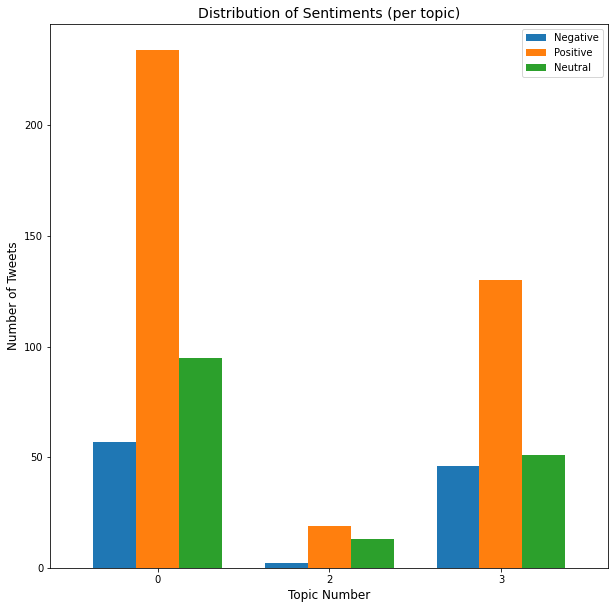

In [34]:
top_index.sort()
columns = ["Negative", "Positive", "Neutral"]
data = []

for topic in top_index:
    curr_topic = wfo_us[wfo_us["Topic"] == topic]
    negative, positive, neutral = len(curr_topic[curr_topic["Sentiment"] == "Negative"]), len(curr_topic[curr_topic["Sentiment"] == "Positive"]), len(curr_topic[curr_topic["Sentiment"] == "Neutral"])
    data.append([negative, positive, neutral])

topic_sentiment_df = pd.DataFrame(data, columns=columns, index=top_index)
topic_sentiment_df.plot(kind="bar", figsize=(10, 10), width=0.75)
plt.title("Distribution of Sentiments (per topic)", fontsize=14)
plt.xlabel("Topic Number", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.gca().xaxis.set_tick_params(rotation=0)
plt.show()

**Label topics**

In [35]:
kw_extractor = yake.KeywordExtractor(top=10)

In [36]:
cluster_keyphrases = dict()

for cluster in top_index:
    tweets = " ".join(wfo_us[wfo_us["Topic"] == cluster].renderedContent)
    cluster_keyphrases[cluster] = [kp[0] for kp in kw_extractor.extract_keywords(tweets)]

In [37]:
keyphrase_column_names = [f"Keyphrase {i}" for i in range(1, 11)]
cluster_keyphrases_df = pd.DataFrame.from_dict(cluster_keyphrases, orient="index", columns=keyphrase_column_names)
cluster_keyphrases_df

,Keyphrase 1,Keyphrase 2,Keyphrase 3,Keyphrase 4,Keyphrase 5,Keyphrase 6,Keyphrase 7,Keyphrase 8,Keyphrase 9,Keyphrase 10
0,freelance writing wfh,employee wfh wfh,wfh freelance writing,wfh writing freelance,wfh day wfh,wfh wfh day,writing freelance wfh,wfh wfh work,wfh employee freelance,day wfh day
2,doot doot doot,imarriedachef rockville maryland,asianfood imarriedachef rockville,egg roll dinner,roll dinner wfh,dinner wfh asianfood,wfh asianfood imarriedachef,chicken teriyaki stir,chicken rockville maryland,rockville maryland chicken
3,wfh wfhlife remotework,pandemiclife wfh wfhlife,wfh wfhlife pandemic,wfhlife pandemic pandemiclife,wfh wfhlife workfromhome,coronavirus pandemic pandemiclife,remotework wfh wfhlife,wfh remotework telework,wfh wfhlife pandemiclife,wfhlife remotework remoteworking


In [38]:
for content in wfo_us[(wfo_us["Topic"] == 3) & (wfo_us["Sentiment"] == "Positive")].renderedContent:
    print(content)

bos tested positive guess bike back home wfh shuck
often hear manager communicating much information sharing accessibility encouragement micromanagement employee leave manager company leadership wfh remote iabc iabcdc
ebernsteinwsj crafting relationship article happy contribute pov lgbtqia parenting estrangement boomer wfh
meghanmbiro authentic employee give best optimize fulfillment wfh empowerment leadership
reminder touch work trust team working remotework wfh
job security come knowing honing using innate talent rely employer certainty wfh personalbranding
occasion want aligned chiropractor auto mechanic corpspeak overit wfh team
remotework arrangement benefit many experience people disability prime example inflexible work design limit access capable employee futureofwork ablest ablism wfh wfhlife
employee want workfromhome least two day week new study show better votedemocrat wfh wfhlife pandemiclife hybrid hybridwork futureofwork disruption office
russia determined cyber attack am